In [1]:
%load_ext autoreload
%autoreload 2

## Setup

In [7]:
import jax
import numpy as np
import matplotlib.pyplot as plt 
import galsim as _galsim

In [8]:
jax.config.update("jax_default_device", jax.devices()[1])

In [9]:
jax.__version__, _galsim.__version__

('0.4.14', '2.4.11')

In [10]:
# Working in float64
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import jax_galsim as galsim
from jax import random

from jax import device_get, device_put

In [11]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from tqdm import tqdm

In [13]:
jax.devices()

[gpu(id=0), gpu(id=1), gpu(id=2), gpu(id=3)]

In [14]:
from utils import get_pc_fig, run_chains, get_summary_from_samples, print_summary_from_samples

## Functions

In [16]:
def add_noise(x:np.ndarray, n=1, nf=1):
    x = x.reshape(1, *x.shape)
    x = x.repeat(n, axis=0)
    noise = np.random.randn(*x.shape) * np.sqrt(BACKGROUND) * nf
    return x + noise, noise

## Fit single galaxy from galsim (no shear)

### global params

In [204]:
PSF_HLR = 0.7
PIXEL_SCALE = 0.2
SLEN = 101
BACKGROUND = 1e4
NOISE = 1

# galaxy
HLR = 0.9
TRUE_FLUX = 1e5
TRUE_LOG_FLUX = np.log10(TRUE_FLUX)

### functions

In [275]:
# get true image
def _draw_gal():
    gal = _galsim.Gaussian(flux=TRUE_FLUX, half_light_radius=HLR)
    psf = _galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = _galsim.Convolve([gal, psf])
    gal_conv = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE)
    im = gal_conv.array
    return im

In [276]:
GSPARAMS = galsim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.jit
@jax.vmap
def draw_gal(lf):
    gal = galsim.Gaussian(flux=10**lf, half_light_radius=HLR)
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE)
    return image.array

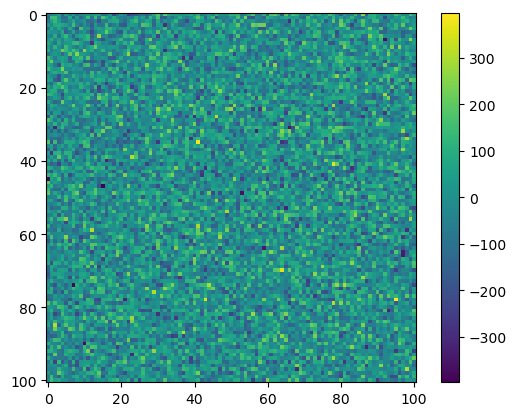

In [208]:
# check error is very small on true thingies
lf = jnp.array([TRUE_LOG_FLUX])
im, _ = add_noise(_draw_gal())
arr = im[0] - draw_gal(lf)[0]
plt.imshow(arr)
plt.colorbar()

### Fit!

In [214]:
def prob_model(data=None):
    batch_dim, _, _ = data.shape
    with numpyro.plate("b", batch_dim, dim=-1):
        lf = numpyro.sample('lf', dist.Uniform(3, 6))
        im = draw_gal(lf)
    numpyro.sample('obs', dist.Normal(im, jnp.sqrt(BACKGROUND)), obs=data)

In [222]:
n_chain = 100
n_vec = 10

In [223]:
TRUE_IMAGE = _draw_gal()
nuts_kernel = NUTS(prob_model)
rng_key = random.PRNGKey(42)

In [224]:
data, noise = add_noise(TRUE_IMAGE, n=n_vec*n_chain, nf=NOISE)
data.shape

(1000, 101, 101)

In [225]:
samples = run_chains(data, nuts_kernel, rng_key, n_vec=n_vec, num_warmup=300, num_samples=1000)

sample: 100%|██████████| 1300/1300 [00:10<00:00, 126.03it/s, 7 steps of size 6.03e-01. acc. prob=0.87]


### Diagnostics

In [407]:
lf = samples['lf']

In [409]:
lf.shape

(1000, 1000)

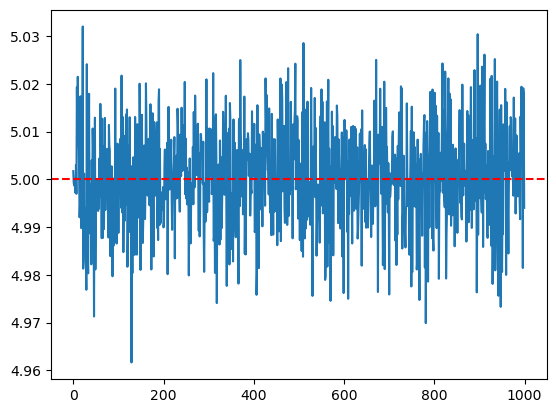

In [411]:
plt.plot(lf[0, :])
plt.axhline(5,color='r', ls='--') 

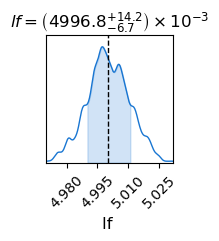

In [369]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_chain({'lf':lf[0,:]}, name='posterior')
fig = c.plotter.plot(truth={'lf':5})

In [396]:
print_summary_from_samples(samples)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     lf[0]      5.00      0.01      5.00      4.98      5.02    949.86      1.46



In [394]:
lf1[..., None].shape

(1, 1000, 1)

In [395]:
summary(lf.T[..., None])

{'Param:0': OrderedDict([('mean', array([5.00029074])),
              ('std', array([0.01078376])),
              ('median', array([5.00044515])),
              ('5.0%', array([4.98239496])),
              ('95.0%', array([5.0178759])),
              ('n_eff', array([949.85795742])),
              ('r_hat', array([1.46074214]))])}

In [403]:
a, b = hpdi(lf, axis=1)
a.shape, b.shape

ValueError: too many values to unpack (expected 2)

In [406]:
summary(lf.flatten(), group_by_chain=False)

{'Param:0': OrderedDict([('mean', 5.000290744901201),
              ('std', 0.01078375698983639),
              ('median', 5.000445150096436),
              ('5.0%', 4.982394959426269),
              ('95.0%', 5.017875895948847),
              ('n_eff', 1074476.1422645957),
              ('r_hat', 1.0000249776768406)])}

In [398]:
lf1 = lf.T[2, None, ...] 
lf1.shape
summary(lf1)

{'Param:0': OrderedDict([('mean', 5.001624842527888),
              ('std', 0.007317461139208172),
              ('median', 5.001632870704569),
              ('5.0%', 4.988986864839171),
              ('95.0%', 5.012661197333769),
              ('n_eff', 1624.018675851857),
              ('r_hat', 0.9992079811645616)])}

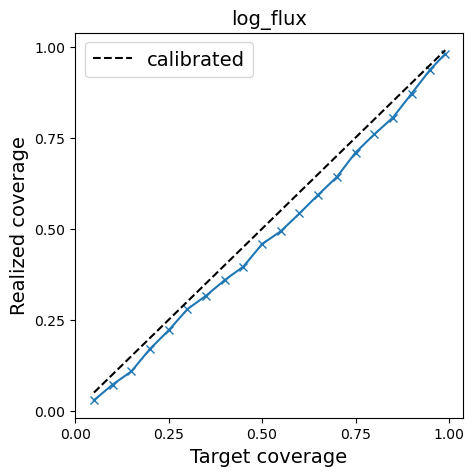

In [272]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
get_pc_fig(ax, lf, 5, param_name='log_flux')

# interpretation: 
# if blue curve is below dotted line, that means that points fall in confidence region less than they should. 
# => predicted uncertainty is smaller than it should be (otherwise more points would be covered) => model is overconfident

In [204]:
# use chain consumer to plot maximum likelihood points 
best_likelihood = dist.Normal(draw_gal(lf.mean(axis=0)), jnp.sqrt(BACKGROUND)).log_prob(all_images).sum(axis=(1, 2)) # likelihood
true_likelihood = dist.Normal(draw_gal(jnp.array([TRUE_LOG_FLUX]*n_chains*n_vec)), jnp.sqrt(BACKGROUND)).log_prob(all_images).sum(axis=(1, 2))

### Chi2

In [234]:
arr1 = all_images[0] - draw_gal(jnp.array([TRUE_LOG_FLUX]))[0]
arr2 = all_images[0] - draw_gal(lf.mean(axis=0)[0, None])[0]
arr1.shape

(101, 101)

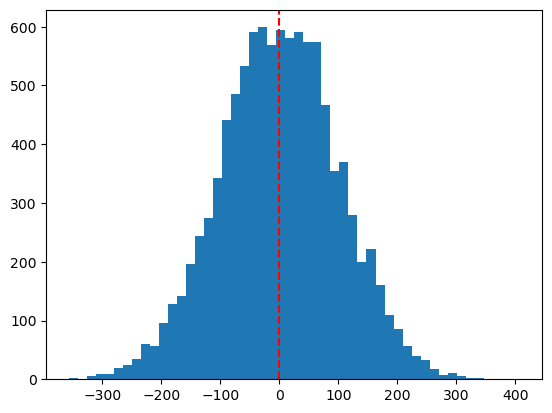

In [237]:
plt.hist(arr1.flatten(), bins=50)
plt.axvline(0, c='r', ls='--')

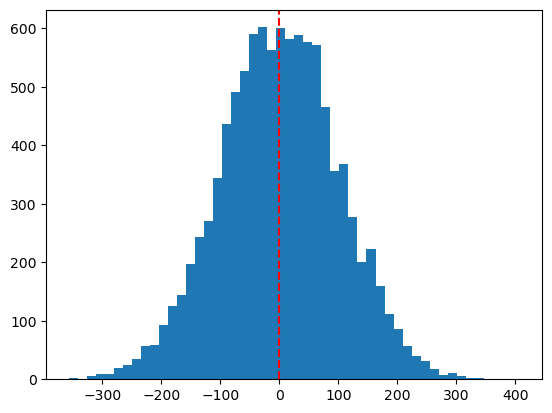

In [238]:
plt.hist(arr2.flatten(), bins=50)
plt.axvline(0, c='r', ls='--')

In [50]:
# same?
from scipy.stats import normaltest
normaltest(arr1.flatten()) # first value: s^2 + k^2, where s is the z-score returned by skewtest and k is the z-score returned by kurtosistest.

NormaltestResult(statistic=4.125547411092673, pvalue=0.12710093993852936)

In [51]:
from scipy.stats import normaltest
normaltest(arr2.flatten())

NormaltestResult(statistic=4.113664852487535, pvalue=0.1278583298268454)

## Fit single gaussian with flux + hlr

In [194]:
PSF_HLR = 0.7
PIXEL_SCALE = 0.2
SLEN = 101
BACKGROUND = 1e4
NOISE = 1

# galaxy
TRUE_HLR = 1.0
LOG_TRUE_FLUX = 5
TRUE_FLUX = 10**LOG_TRUE_FLUX

#params
TRUE_PARAMS = {'lf': LOG_TRUE_FLUX, 'hlr': TRUE_HLR}
TRUE_PARAMS_ARR = {k:jnp.array([v]) for k,v in TRUE_PARAMS.items()}

In [195]:
# get true image
def _draw_gal(noise=NOISE):
    gal = _galsim.Gaussian(flux=TRUE_FLUX, half_light_radius=TRUE_HLR)
    psf = _galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = _galsim.Convolve([gal, psf])
    gal_conv = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE)
    im = gal_conv.array
    im += np.random.randn(*im.shape) * np.sqrt(BACKGROUND) * noise
    return im

In [196]:
GSPARAMS = galsim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.jit
def draw_gal(lf, hlr):
    gal = galsim.Gaussian(flux=10**lf, half_light_radius=hlr)
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE)
    return image.array

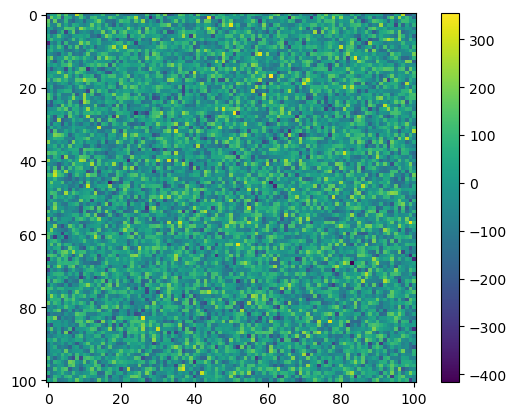

In [197]:
# check error is very small on true thingies
arr = _draw_gal() - draw_gal(**TRUE_PARAMS_ARR)
plt.imshow(arr)
plt.colorbar()

In [203]:
def prob_model(y=None):
    params = {
        'lf': numpyro.sample('lf', dist.Uniform(4.5,5.5)),
        'hlr': numpyro.sample('hlr', dist.Uniform(0.7, 1.5)),
    }
    params = {k:jnp.array([v]) for k,v in params.items()}
    im = draw_gal(**params)
    numpyro.sample('obs', dist.Normal(im, jnp.sqrt(BACKGROUND)), obs=y)

In [204]:
TRUE_IMAGE = _draw_gal()
nuts_kernel = NUTS(prob_model, max_tree_depth=10) 
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=4000)
rng_key = random.PRNGKey(2)
mcmc.run(rng_key, y=TRUE_IMAGE)

sample: 100%|██████████| 6000/6000 [00:23<00:00, 260.72it/s, 1 steps of size 5.08e-01. acc. prob=0.94] 


In [205]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       hlr      1.00      0.03      1.00      0.96      1.05   1513.65      1.00
        lf      4.99      0.01      4.99      4.97      5.01   1534.03      1.00

Number of divergences: 0


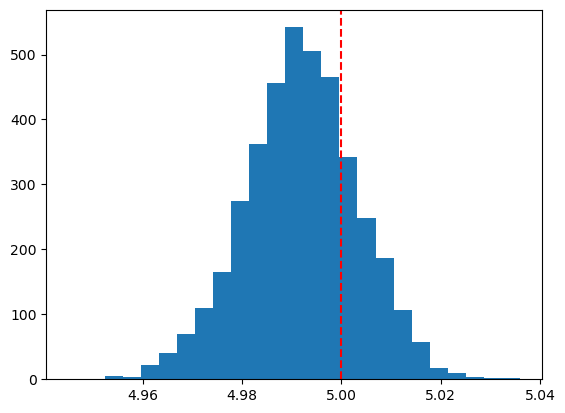

In [206]:
plt.hist(mcmc.get_samples()['lf'], bins=25)
plt.axvline(LOG_TRUE_FLUX, ls='--', color='r')

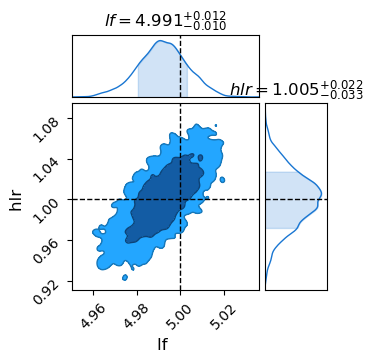

In [207]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
res = mcmc.get_samples()
c.add_chain(
    {k:res[k] for k in ['lf', 'hlr']},
    name='Posterior'
)
fig = c.plotter.plot(truth=TRUE_PARAMS)

In [208]:
dist.Normal(draw_gal(**TRUE_PARAMS_ARR), jnp.sqrt(BACKGROUND)).log_prob(TRUE_IMAGE).sum() # max 

Array(-61502.64, dtype=float32)

In [209]:
mean_params = {k:jnp.array([jnp.mean(v)]) for k,v in mcmc.get_samples().items()}
dist.Normal(draw_gal(**mean_params), jnp.sqrt(BACKGROUND)).log_prob(TRUE_IMAGE).sum()

Array(-61502.156, dtype=float32)

## Fit single gaussian galaxy with shear (and other parameters)

In [42]:
PSF_HLR = 0.7
PIXEL_SCALE = 0.2
SLEN = 101
BACKGROUND = 1e4

# galaxy
TRUE_HLR = 0.9
LOG_TRUE_FLUX = 5
TRUE_FLUX = 10**LOG_TRUE_FLUX
TRUE_X = 0.
TRUE_Y = 0.
 
#shear
G1 = 0.02
G2 = 0.0

#params
TRUE_PARAMS = {'lf': LOG_TRUE_FLUX, 'hlr': TRUE_HLR, 'x': TRUE_X, 'y': TRUE_Y, 'g1': G1, 'g2': G2}
TRUE_PARAMS_ARR = {k:jnp.array([v]) for k,v in TRUE_PARAMS.items()}

In [43]:
# get true image
def _draw_gal():
    gal = _galsim.Gaussian(flux=TRUE_FLUX, half_light_radius=TRUE_HLR)
    gal = gal.shear(g1=G1, g2=G2)
    pos = _galsim.PositionD(x=TRUE_X, y=TRUE_Y)
    psf = _galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = _galsim.Convolve([gal, psf])
    gal_conv = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE, 
                                  offset=pos)
    im = gal_conv.array
    return im

In [44]:
im = _draw_gal()
print('snr:', np.sqrt(np.sum(im * im / (BACKGROUND + im))))

snr: 56.890995


In [45]:
GSPARAMS = galsim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.jit
@jax.vmap
def draw_gal(lf, hlr, x, y, g1, g2):
    gal = galsim.Gaussian(flux=10**lf, half_light_radius=hlr)
    gal = gal.shear(g1=g1, g2=g2)
    pos = galsim.PositionD(x=x, y=y)
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 offset=pos, 
                                 )
    return image.array

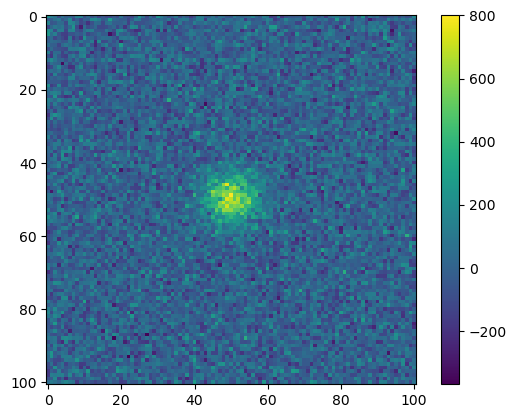

In [46]:
# check error is very small on true thingies
TRUE_IMAGE = _draw_gal()
im, _ = add_noise(TRUE_IMAGE, nf=1)
arr = im
# - draw_gal(**TRUE_PARAMS_ARR)
plt.imshow(arr[0])
plt.colorbar()

In [48]:
def prob_model(data=None):
    batch_dim, _, _ = data.shape
    with numpyro.plate('b', batch_dim, dim=-1):
        lf = numpyro.sample('lf', dist.Uniform(4,6))
        hlr = numpyro.sample('hlr', dist.Uniform(0.5, 1.5))
        x = numpyro.sample('x', dist.Uniform(-0.5, 0.5))
        y = numpyro.sample('y', dist.Uniform(-0.5, 0.5))
        g1 = numpyro.sample('g1', dist.Uniform(-0.1, 0.1))
        g2 = numpyro.sample('g2', dist.Uniform(-0.1, 0.1))
    im = draw_gal(lf, hlr, x, y, g1, g2)
    numpyro.sample('obs', dist.Normal(im, jnp.sqrt(BACKGROUND)), obs=data)

In [49]:
data, _ = add_noise(TRUE_IMAGE, n=1, nf=1)
nuts_kernel = NUTS(prob_model, max_tree_depth=10)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2000, num_chains=1)
rng_key = random.PRNGKey(42)
mcmc.run(rng_key, data=data)

sample: 100%|██████████| 2500/2500 [00:29<00:00, 83.82it/s, 7 steps of size 5.24e-01. acc. prob=0.91]  


In [50]:
mcmc.get_samples(group_by_chain=True)['g1'].shape

(1, 2000, 1)

In [428]:
print_summary(mcmc.get_samples(group_by_chain=True))


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     g1[0]      0.00      0.03      0.00     -0.05      0.05   3462.76      1.00
     g2[0]      0.04      0.03      0.04     -0.01      0.08   4014.97      1.00
    hlr[0]      0.88      0.03      0.88      0.84      0.92   2960.45      1.00
     lf[0]      4.98      0.01      4.98      4.97      5.00   2890.64      1.00
      x[0]      0.07      0.12      0.07     -0.13      0.26   5245.86      1.00
      y[0]     -0.06      0.12     -0.06     -0.25      0.16   5330.38      1.00



In [348]:
from numpyro.diagnostics import summary, gelman_rubin, effective_sample_size, print_summary
g1, g2 = mcmc.get_samples(group_by_chain=True)['g1'], mcmc.get_samples(group_by_chain=True)['g2'], 
print_summary({'g1':g1, 'g2':g2}, group_by_chain=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     g1[0]     -0.01      0.03     -0.01     -0.05      0.04   2612.71      1.00
     g2[0]      0.02      0.03      0.02     -0.02      0.07   2733.35      1.00



In [357]:
g1 = mcmc.get_samples(group_by_chain=True)['g1'][:, :, 0]
g1 = jnp.concatenate([g1, g1], axis=0)
summary(g1, group_by_chain=True), g1.shape

({'Param:0': OrderedDict([('mean', -0.007847328948608213),
               ('std', 0.029113640327228945),
               ('median', -0.008088943593189069),
               ('5.0%', -0.05434753758735851),
               ('95.0%', 0.04017590129294596),
               ('n_eff', 5273.670517807214),
               ('r_hat', 0.9995277447676445)])},
 (2, 2000))

In [351]:
g1.shape

(2, 2000, 1)

In [36]:
mcmc.get_samples()['g1'].shape

(2000, 1)

In [61]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     g1[0]      0.01      0.03      0.01     -0.04      0.06   3021.19      1.00
     g2[0]     -0.03      0.03     -0.03     -0.08      0.01   2800.88      1.00
    hlr[0]      0.92      0.03      0.91      0.87      0.96   1485.75      1.00
     lf[0]      5.00      0.01      5.00      4.98      5.02   1599.50      1.00
      x[0]      0.07      0.13      0.07     -0.14      0.27   3323.87      1.00
      y[0]     -0.25      0.11     -0.25     -0.43     -0.06   2000.73      1.00

Number of divergences: 0


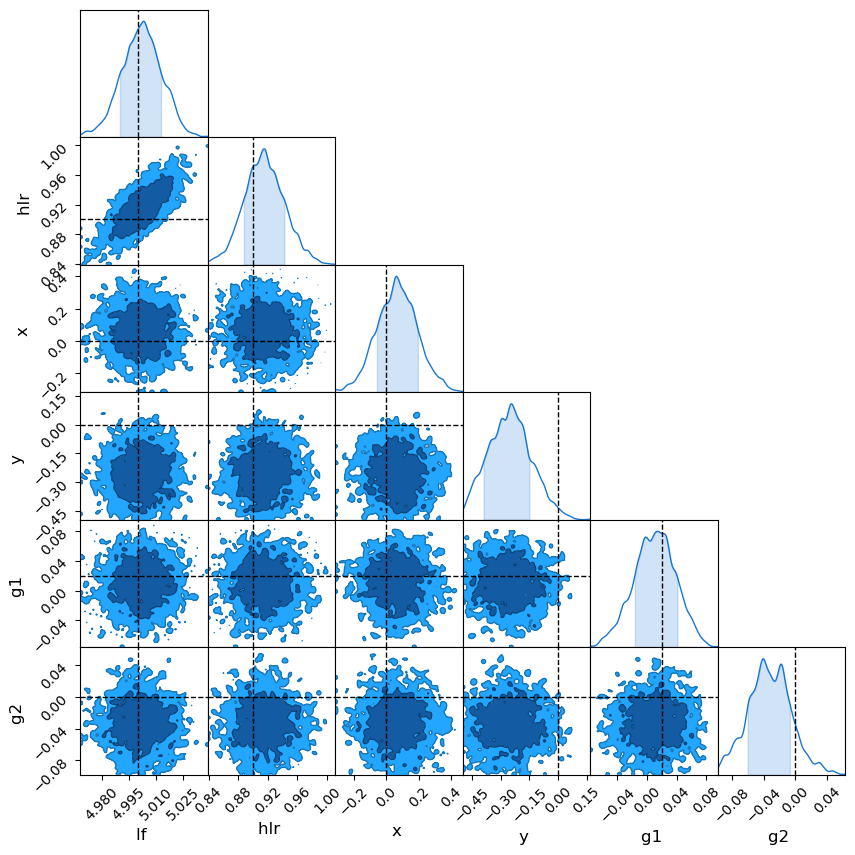

In [51]:
# example of corner plots
from chainconsumer import ChainConsumer
c = ChainConsumer()
res = mcmc.get_samples()
c.add_chain(
    {k:res[k][:, 0] for k in ['lf', 'hlr', 'x', 'y', 'g1', 'g2']},
    name='Posterior'
)
fig = c.plotter.plot(truth=TRUE_PARAMS)

In [58]:
from numpyro.diagnostics import hpdi
g1 = mcmc.get_samples()['g1']
hpdi(g1, prob=0.9, axis=0), hpdi(g1, prob=0.01, axis=0)

(array([[-0.03570957],
        [ 0.05800452]]),
 array([[0.0089669 ],
        [0.00930985]]))

In [76]:
# collect samples
samples = {p:np.zeros((2000, n_chains*n_vec)) for p in all_samples[0]}
for ii in range(n_chains):
    for p in all_samples[ii]:
        p_ii = all_samples[ii][p]
        samples[p][:, ii*n_vec:(ii+1)*n_vec] = p_ii

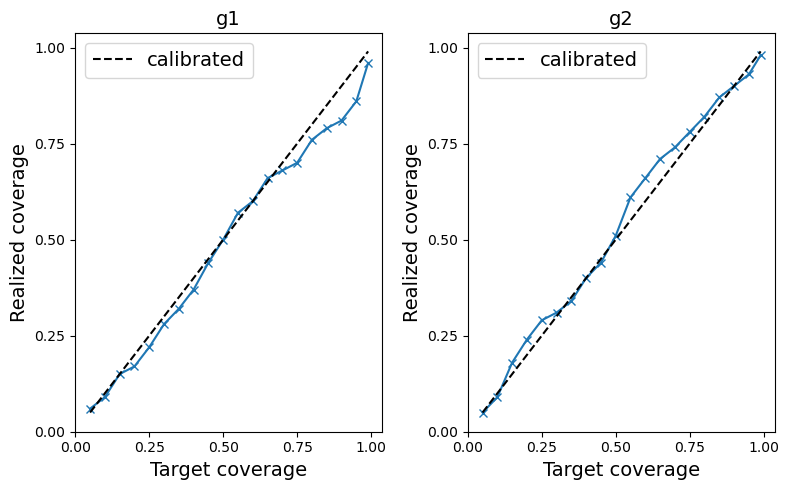

In [84]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))
get_pc_fig(samples['g1'], G1, ax1, param='g1')
get_pc_fig(samples['g2'], G2, ax2, param='g2')
plt.tight_layout()

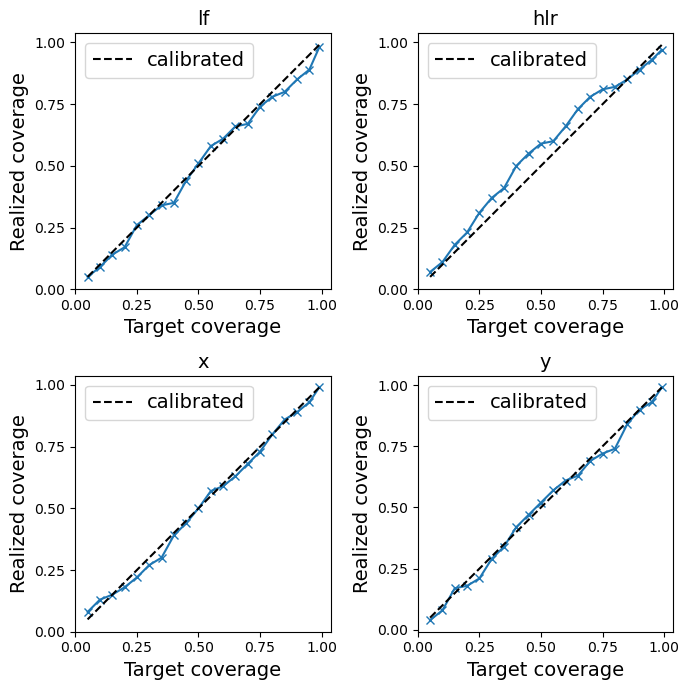

In [90]:
fig, [[ax1, ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(7,7))
get_pc_fig(samples['lf'], LOG_TRUE_FLUX, ax1, param='lf')
get_pc_fig(samples['hlr'], TRUE_HLR, ax2, param='hlr')
get_pc_fig(samples['x'], TRUE_X, ax3, param='x')
get_pc_fig(samples['y'], TRUE_Y, ax4, param='y')
plt.tight_layout()

In [297]:
dist.Normal(draw_gal(**TRUE_PARAMS_ARR), jnp.sqrt(BACKGROUND)).log_prob(TRUE_IMAGE).sum()

Array(-61471.887, dtype=float32)

In [298]:
mean_params = {k:jnp.array([jnp.mean(v)]) for k,v in mcmc.get_samples().items()}
dist.Normal(draw_gal(**mean_params), jnp.sqrt(BACKGROUND)).log_prob(TRUE_IMAGE).sum()

Array(-61470.22, dtype=float32)

In [74]:
all_samples

{0: {'g1': Array([[-0.02138838,  0.03330313,  0.03805733, ...,  0.0243239 ,
           0.00941016,  0.01114192],
         [-0.00882747, -0.02966039,  0.06010782, ...,  0.00407769,
           0.02173774,  0.04441378],
         [-0.00588793,  0.00938019,  0.03312243, ...,  0.04835801,
          -0.02329236,  0.03796267],
         ...,
         [ 0.00972159, -0.03653179,  0.04972386, ..., -0.06331007,
           0.0205459 , -0.00249025],
         [-0.05065237,  0.03694061,  0.08745187, ...,  0.06469119,
          -0.00434732,  0.06249934],
         [-0.0540263 , -0.05401625,  0.0204233 , ..., -0.05171325,
          -0.01325212,  0.09916658]], dtype=float64),
  'g2': Array([[-0.04639904, -0.00320375, -0.02161355, ..., -0.00052567,
           0.04773285,  0.02441001],
         [-0.03318863, -0.02876019,  0.00273526, ...,  0.02323361,
          -0.01731411,  0.03312418],
         [-0.05796091,  0.00768991, -0.03838132, ...,  0.04935835,
           0.00561672,  0.01140751],
         ...,
    

In [86]:
samples['g1'].mean(), samples['g1'].std()

(0.023389126833173, 0.03856900724650697)